In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
from serial import Serial
from math import pi, cos, sin
import numpy as np
%matplotlib inline

In [2]:
df2 = pd.read_csv('points2.txt')
df2.drop(df2.columns[0],axis=1, inplace=True)

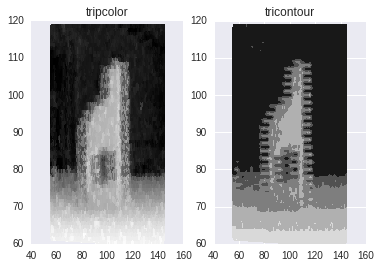

In [41]:
fig, (ax, ax2)=plt.subplots(ncols=2)
ax.set_title("tripcolor")
ax.tripcolor(df2["x"], df2["y"], df2["z"])
ax2.set_title("tricontour")
ax2.tricontourf(df2["x"], df2["y"], df2["z"])

plt.show()

In [32]:
def get_euler(cxn):
    serial_val = cxn.readline()
    if len(serial_val) >= 8:
        try:
            serial_str = serial_val[:-2].decode("utf-8")
        except:
            pass
        str_split = serial_str.split('x')
        if '' not in str_split:
            return str_split


def rotz(theta): # Generates a z-axis rotation matrix for a given angle
    return [[cos(theta), -sin(theta), 0],
            [sin(theta), cos(theta), 0],
            [0, 0, 1]]


def roty(phi): # Generates a y-axis rotation matrix for a given angle
    return [[1, 0, 0],
            [0, cos(phi), sin(phi)],
            [0, -sin(phi), cos(phi)]]


def get_origin(theta, phi):
    origin_init = [0, 0, 0] # Leaving this as 0 since the current pan/tilt design has no offset
    return np.dot(roty(phi), np.dot(rotz(theta), origin_init))


def transform_points(thetas, phis, lens):
    points = []
    points_euler = list(zip(thetas, phis, lens))
    points_cart = [point_transform(*point) for point in points_euler]
    print(points)
    return points_cart


def point_transform(theta, phi, dist):
    point_euler = [int(theta)*(pi/180), int(phi)*(pi/180), int(dist)/100]
    origin_point = get_origin(*point_euler[:-1]) # account for movement of the origin of the sensor
    orig_vec = [0, point_euler[2], 0] # The original vector
    point_transform = np.dot(roty(point_euler[1]), np.dot(rotz(point_euler[0]), orig_vec))
    return point_transform+origin_point

In [34]:
cxn = Serial('/dev/ttyACM0', baudrate=38400)

all_points = []
while(len(all_points) < 60*90):
    if cxn.inWaiting:
        euler = get_euler(cxn)
        if euler:
            if '$' in ''.join(euler):
                break
            all_points.append(euler)

df = pd.DataFrame(list(all_points), columns=list('xyz'))
print(df)
df.to_csv('points2.txt')

        x    y   z
0     100   60  24
1     101   60  23
2     102   60  21
3     103   60  23
4     104   60  23
5     105   60  17
6     106   60  23
7     107   60   8
8     108   60  23
9     109   60  23
10    110   60  23
11    111   60  23
12    112   60  23
13    113   60  22
14    114   60  23
15    115   60  23
16    116   60  23
17    117   60  22
18    118   60  23
19    119   60  23
20    120   60   6
21    121   60  23
22    122   60  23
23    123   60  23
24    124   60  23
25    125   60  22
26    126   60  23
27    127   60  23
28    128   60  24
29    129   60  22
...   ...  ...  ..
5325   85  119  80
5326   84  119  79
5327   83  119  82
5328   82  119  82
5329   81  119  84
5330   80  119  83
5331   79  119  77
5332   78  119  82
5333   77  119  81
5334   76  119  80
5335   75  119  80
5336   74  119  80
5337   73  119  82
5338   72  119  81
5339   71  119  78
5340   70  119  80
5341   69  119  78
5342   68  119  78
5343   67  119  78
5344   66  119  74
5345   65  1

In [40]:
df2 = df.astype(int)

AttributeError: 'PolyCollection' object has no attribute 'invert_xaxis'

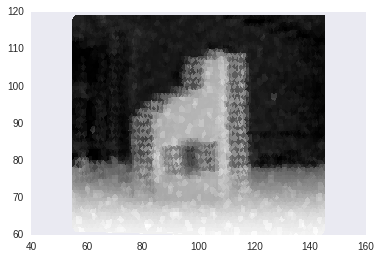

In [45]:
plt.tripcolor(df2['x'],df2['y'],df2['z']).invert_xaxis()

In [15]:
refV = 4.9
calib = pd.DataFrame([[24, 440*refV],[60,190*refV]],columns=['dist','voltage'])
test = pd.DataFrame([[20, 500*refV],[30,400*refV],[40,300*refV],[50,240*refV],[70,160*refV]],columns=['dist','voltage'])

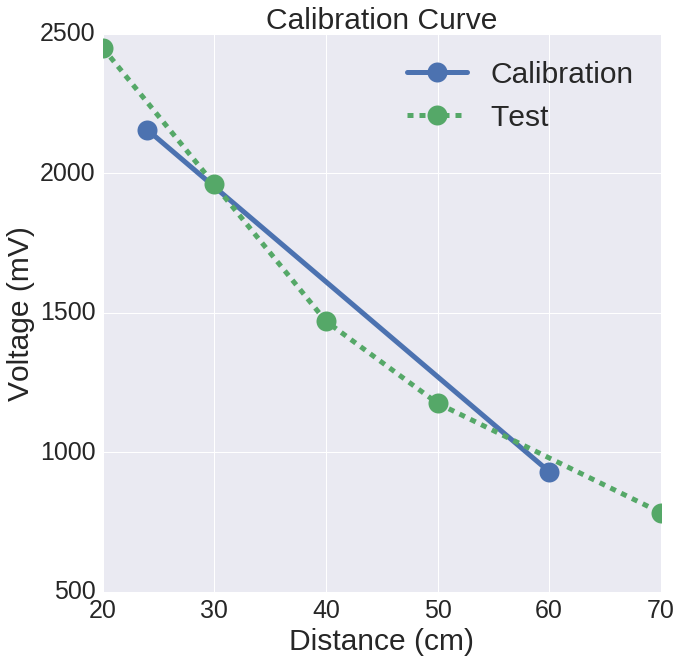

In [33]:
fig, ax = plt.subplots(figsize=(10, 10))
line1, = ax.plot(calib['dist'], calib['voltage'], '-', marker='o', linewidth=5, markersize=20,label='Calibration')
line2, = ax.plot(test['dist'], test['voltage'], '--', marker='o', linewidth=5,markersize=20,label='Test')
ax.set_xlabel('Distance (cm)',fontsize=30)
ax.set_ylabel('Voltage (mV)',fontsize=30)
ax.set_title('Calibration Curve',fontsize=30)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
ax.legend(loc='upper right',fontsize=30)

$$ d=\frac{(V_{in}-V_{calibmin})(d_{calibmax}-d_{calibmin})}{V_{calibmax}-V_{calibmin}}+d_{calibmin} $$

In [35]:
190*refV

931.0000000000001

In [16]:
def cal_func(mV):
    return (((mV - 440*refV) *(60 - 24)) / ((190 - 440) * refV)) + 24

In [19]:
pred = [cal_func(mV) for mV in [500*refV, 400*refV, 300*refV, 240*refV, 160*refV]]
standard = [10, 80]

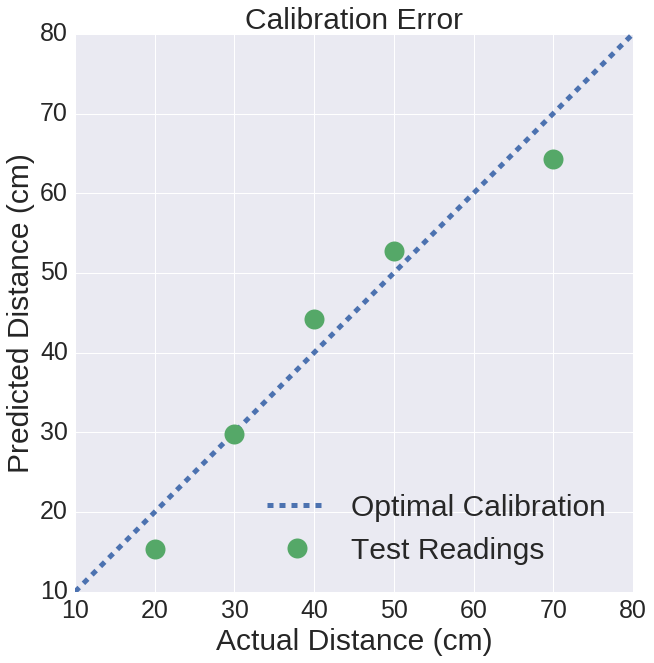

In [32]:
fig, ax = plt.subplots(figsize=(10, 10))
line1, = ax.plot(standard, standard, '--', marker='o', linewidth=5, markersize=0,label='Optimal Calibration')
line2, = ax.plot(test['dist'], pred, ' ', marker='o', linewidth=5,markersize=20,label='Test Readings')
ax.set_xlabel('Actual Distance (cm)',fontsize=30)
ax.set_ylabel('Predicted Distance (cm)',fontsize=30)
ax.set_title('Calibration Error',fontsize=30)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
ax.legend(loc='lower right',fontsize=30)